# **GEOG5404M: Analytics for Urban Policy**

# Don’t Silence the Data: Forecasting Leeds' Noise Complaints to Evaluate Service Discontinuation

*SID: 201530247*

This notebook explores 10 years of out-of-hours noise complaints to inform Leeds City Council's decision to discontinue the service for out-of-hours noise complaints under cost-saving plans. We will apply seasonal decomposition, forecasting models (SARIMA, Holt-Winters), and compare performance with simple baselines.

**Research Questions**:

1.   What are the long-term temporal trends in out-of-hours noise complaints in Leeds over the past decade?
2.   To what extent can numbers of future noise complaints be predicted?
3.   What is the likely impact of Leeds City Council's decision to discontinue the out-of-hours service?


This analysis employs a **retrospective** forecasting approach. We will use historical data (2013-2024) to build models that predict future noise complaint volumes under the assumption that historical patterns and the existing out-of-hours noise complaint system would continue.

## Data Merging & Preprocessing

To begin, we will import the required libraries for our analysis.

In [1]:
# importing required libraries
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import re
import geopandas as gpd
import seaborn as sns
from dateutil import parser

We will then import our datasets, taken from [Data Mill North - Out of Hours Noise Complaint data](https://datamillnorth.org/dataset/2gpnr/noise-nuisance-out-of-hours).

In [2]:
# importing noise complaint out of hours data, april 2013 - september 2024
noise_list = [
    pd.read_csv("april 2013 to dec 2016.csv"),
    pd.read_csv("january to march 2017.csv"),
    pd.read_csv("april to june 2017.csv"),
    pd.read_csv("june to september 2017.csv"),
    pd.read_csv("oct 2017 to mar 2018.csv"),
    pd.read_csv("april 2018 to march 2019.csv"),
    pd.read_csv('April 2019.csv'),
    pd.read_csv("may to sept 2019.csv"),
    pd.read_csv("october 2019 to march 2020.csv"),
    pd.read_csv("april to december 2020.csv"),
    pd.read_csv("january to june 2021.csv"),
    pd.read_csv("july to november 2021.csv"),
    pd.read_csv("december 2021 to march 2022.csv"),
    pd.read_csv("april to july 2022.csv"),
    pd.read_csv("august to december 2022.csv"),
    pd.read_csv("january to may 2023.csv"),
    pd.read_csv("june to september 2023.csv"),
    pd.read_csv("october 2023 to march 2024.csv"),
    pd.read_csv("april to may 2024.csv"),
    pd.read_csv("june 2024.csv"),
    pd.read_csv("july 2024.csv"),
    pd.read_csv("august 2024.csv"),
    pd.read_csv("september 2024.csv"),
]

To start merging the datasets together, we will clean and standardise their column names and formats to ensure consistency before concatenating them into a single dataset for analysis.

In [3]:
# dictionary for columns

columns_fix = {
    'Date': 'Created',
    'Created': 'Created',
    'Created1': 'Created',
    'Caller': 'Caller Postcode',
    'CallerPostcode': 'Caller Postcode',
    'Caller_Postcode': 'Caller Postcode',
    'Caller Postcode': 'Caller Postcode',
    'post code': 'Caller Postcode',
    'Caller Postcode ': 'Caller Postcode',
    'Postcode': 'Caller Postcode',
    'Noise Postcode': 'Caller Postcode',
    'Noise Postode': 'Caller Postcode',
    'Address': 'Caller Postcode',
    'Occurrence': 'Type of Noise Causing a Nuisance',
    'Noise type': 'Type of Noise Causing a Nuisance',
    'Type of Noise': 'Type of Noise Causing a Nuisance',
    'Noise Type': 'Type of Noise Causing a Nuisance',
    'Type of ASB': 'Type of Noise Causing a Nuisance',
    'Enq_Type': 'Enq_Type',
    'Enq_type': 'Enq_Type',
    'Enq Type': 'Enq_Type',
    'Enq Type ': 'Enq_Type',
    'Accused': 'Accused Postcode',
    'Accused Postcode': 'Accused Postcode',
    'AccusedPostcode': 'Accused Postcode',
}

In [4]:
def clean_noise(noise):
    noise = noise.dropna(axis=1, how='all') # drop any columns where all values are missing
    noise.columns = [col.strip() for col in noise.columns] # get rid of whitespace from column names
    noise = noise.rename(columns={col: columns_fix.get(col, col) for col in noise.columns}) # rename columns using our dictionary
    noise = noise.loc[:, ~noise.columns.duplicated()] # drop any duplicate columns

    unparsed_count = 0

# date string parsing
    if 'Created' in noise.columns:
        def safe_parse(date_str):
            try:
                return parser.parse(str(date_str), dayfirst=True)
            except Exception:
                return pd.NaT

        noise['Created'] = noise['Created'].apply(safe_parse)
        unparsed_count = noise['Created'].isna().sum()

        noise['Date'] = noise['Created'].dt.normalize()
        noise['Year'] = noise['Created'].dt.year

    return noise, unparsed_count

In [5]:
# applying our clean_noise function to each of the dataframes
all_clean_data = [clean_noise(noise)[0] for noise in noise_list]
noise = pd.concat(all_clean_data, ignore_index=True) # joining all data

In [6]:
noise, missing_count = clean_noise(noise) # applying clean_noise on the combined dataframe to catch any inconsistencies

This step is crucial because the raw files vary slightly in column names and completeness.

In [7]:
noise.head() # checking to see if this has worked

,Created,Type of Noise Causing a Nuisance,Caller Postcode,Sr_Num,Enq_Type,Unnamed: 7,Year,Accused Postcode,Date
0,2013-01-04,Alarm,LS1 6,OutofHours,OutofHours,NaN,2013,NaN,2013-01-04
1,2013-01-04,Alarm,LS6 1,OutofHours,OutofHours,NaN,2013,NaN,2013-01-04
2,2013-01-04,Other,LS13 2,OutofHours,OutofHours,NaN,2013,NaN,2013-01-04
3,2013-01-04,DIY,LS9 6,OutofHours,OutofHours,NaN,2013,NaN,2013-01-04
4,2013-01-04,Barking Dog,LS13 2,OutofHours,OutofHours,NaN,2013,NaN,2013-01-04


This has worked successfully, and now a subset with all the required columns for analysis is created.

In [8]:
noise = noise[['Type of Noise Causing a Nuisance','Caller Postcode','Year','Date']] # creating a subset of our wanted columns

Since the datasets vary slightly in structure, we will verify whether the noise type variables are consistently labeled across them.

In [9]:
noise['Type of Noise Causing a Nuisance'].unique()

array(['Alarm', 'Other', 'DIY', 'Barking Dog', 'Music', 'Party', 'TV',
       'tv', 'alarm', 'music', 'Shouting', 'Dog',
       'Domestic Abuse - ring 999', 'Dog Barking', 'Building site',
       'Noise associated with licensed premise',
       'Banging on walls/ceiling/floor', nan,
       'Noise associated with licensed premises', 'MUSIC', 'PARTY',
       'DOG BARKING', 'ALARM', 'BANGING ON WALLS/CEILING/FLOOR',
       'BUILDING SITE', 'OTHER', 'SHOUTING',
       'NOISE ASSOCIATED WITH LICENSED PREMISES',
       'DOMESTIC ABUSE (CALL 999)', 'SELECT FROM LIST...',
       '<NO ANSWER RECORDED>', 'LOUD MUSIC',
       'NOISE ASSOCIATED WITH LICENCED PREMISES', 'Loud Music',
       'Banging On Walls/Ceiling/Floor', 'Building Site', 'Please select'],
      dtype=object)

Given the significant differences in how noise types are labeled, we will standardise them through mapping to ensure consistency and allow for an easier analysis.

In [10]:
# creating a dictionary for noise type names
noise_mapping = {
    'alarm': 'Alarm',
    'ALARM': 'Alarm',
    'Alarm': 'Alarm',

    'barking dog': 'Dog Barking',
    'DOG BARKING': 'Dog Barking',
    'Dog Barking': 'Dog Barking',
    'Dog': 'Dog Barking',
    'Barking Dog': 'Dog Barking',


    'music': 'Loud Music',
    'LOUD MUSIC': 'Loud Music',
    'Music': 'Loud Music',
    'MUSIC': 'Loud Music',

    'party': 'Party',
    'PARTY': 'Party',
    'Party': 'Party',

    'tv': 'TV',
    'TV': 'TV',

    'shouting': 'Shouting',
    'SHOUTING': 'Shouting',
    'Shouting': 'Shouting',

    'DIY': 'DIY',
    'diy': 'DIY',

    'OTHER': 'Other',
    'Other': 'Other',

    'banging on walls/ceiling/floor': 'Banging on Walls/Ceiling/Floor',
    'Banging on walls/ceiling/floor': 'Banging on Walls/Ceiling/Floor',
    'BANGING ON WALLS/CEILING/FLOOR': 'Banging on Walls/Ceiling/Floor',
    'Banging On Walls/Ceiling/Floor': 'Banging on Walls/Ceiling/Floor',

    'Building site': 'Building Site',
    'BUILDING SITE': 'Building Site',
    'Building Site': 'Building Site',

    'Noise associated with licensed premises': 'Licensed Premises',
    'NOISE ASSOCIATED WITH LICENSED PREMISES': 'Licensed Premises',
    'Noise associated with licensed premise': 'Licensed Premises',
    'NOISE ASSOCIATED WITH LICENCED PREMISES': 'Licensed Premises',

    'Domestic Abuse - ring 999': 'Domestic Abuse',
    'DOMESTIC ABUSE (CALL 999)': 'Domestic Abuse',

    'SELECT FROM LIST...': None,
    '<NO ANSWER RECORDED>': None,
    'Please select': None,
    'Other': None,
}

In [11]:
col = 'Type of Noise Causing a Nuisance'
noise[col] = noise[col].str.strip().map(noise_mapping).fillna(noise[col].str.strip())

In [12]:
drop_values = ['nan', 'please select', 'select from list...', '<no answer recorded>', 'other']
noise.dropna(subset=['Caller Postcode'], inplace=True)

noise = noise[~noise[col].str.lower().isin(drop_values)]
noise = noise[noise[col].notna()]

In [13]:
noise['Type of Noise Causing a Nuisance'].value_counts(dropna=False)

,count
Type of Noise Causing a Nuisance,
Loud Music,58325
Party,11362
Shouting,9162
Banging on Walls/Ceiling/Floor,7014
Dog Barking,4628
TV,2742
Alarm,2528
DIY,1401
Building Site,609


Now that our dataset is clean, we will move on to some preprocessing for the temporal analysis.

In [14]:
noise['Date'] = pd.to_datetime(noise['Date'], errors='coerce')
noise_indexed = noise.set_index('Date')

monthly_counts = noise_indexed.resample('M').size().to_frame(name='Count')


<ipython-input-14-959488a9d6e5>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = noise_indexed.resample('M').size().to_frame(name='Count')


## Data Exploration

We begin by exploring the structure and content of the noise complaint dataset. This step helps us understand the volume and distribution of the data before moving into time series analysis.


In [15]:
noise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98126 entries, 0 to 103083
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Type of Noise Causing a Nuisance  98126 non-null  object        
 1   Caller Postcode                   98126 non-null  object        
 2   Year                              98126 non-null  int32         
 3   Date                              98126 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 3.4+ MB


The final merged dataset contains 98,126 noise complaint values over 11 years.

In [16]:
# complaints per year
noise['Year'].value_counts().sort_index()

,count
Year,
2013,6284
2014,5927
2015,7826
2016,8374
2017,8583
2018,9128
2019,7836
2020,10799
2021,10129


In [17]:
# complaints by type of noise
noise['Type of Noise Causing a Nuisance'].value_counts()

,count
Type of Noise Causing a Nuisance,
Loud Music,58325
Party,11362
Shouting,9162
Banging on Walls/Ceiling/Floor,7014
Dog Barking,4628
TV,2742
Alarm,2528
DIY,1401
Building Site,609


In [18]:
noise['Date'] = pd.to_datetime(noise['Date'])

# group by date and noise Type, then resample monthly
monthly_by_type = (
    noise
    .groupby(['Type of Noise Causing a Nuisance', pd.Grouper(key='Date', freq='M')])
    .size()
    .reset_index(name='Count')
)

# pivot to get noise types as separate columns
monthly_pivot = monthly_by_type.pivot(index='Date', columns='Type of Noise Causing a Nuisance', values='Count').fillna(0)


<ipython-input-18-cea26c1a4c11>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(['Type of Noise Causing a Nuisance', pd.Grouper(key='Date', freq='M')])


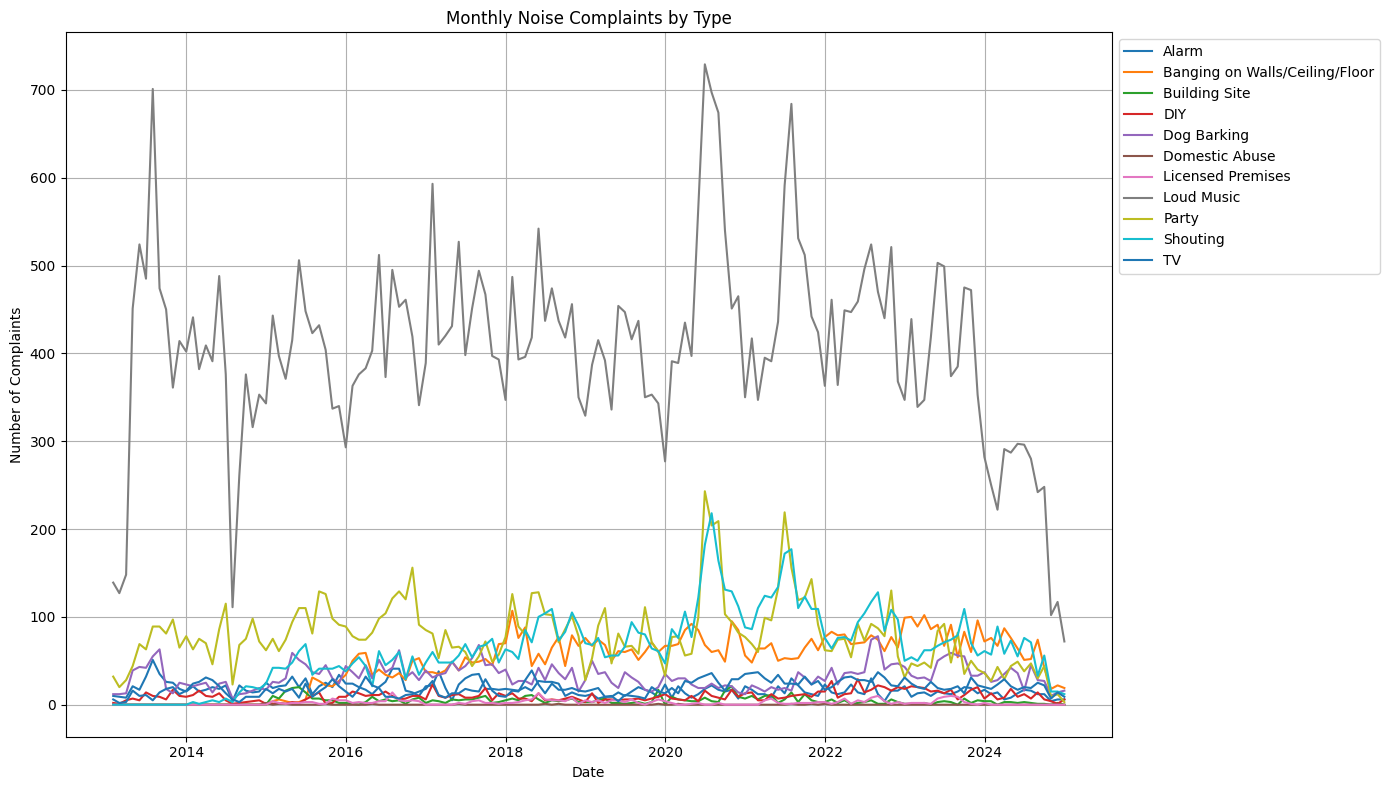

In [19]:
# plotting monthly noise complaints by type
plt.figure(figsize=(14, 8))
for column in monthly_pivot.columns:
    plt.plot(monthly_pivot.index, monthly_pivot[column], label=column)

plt.title('Monthly Noise Complaints by Type')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.grid(True)
plt.show()

Loud music is the most common noise complaint over all of the years. Let's remove it for the next graph to see the other variables slightly clearer.

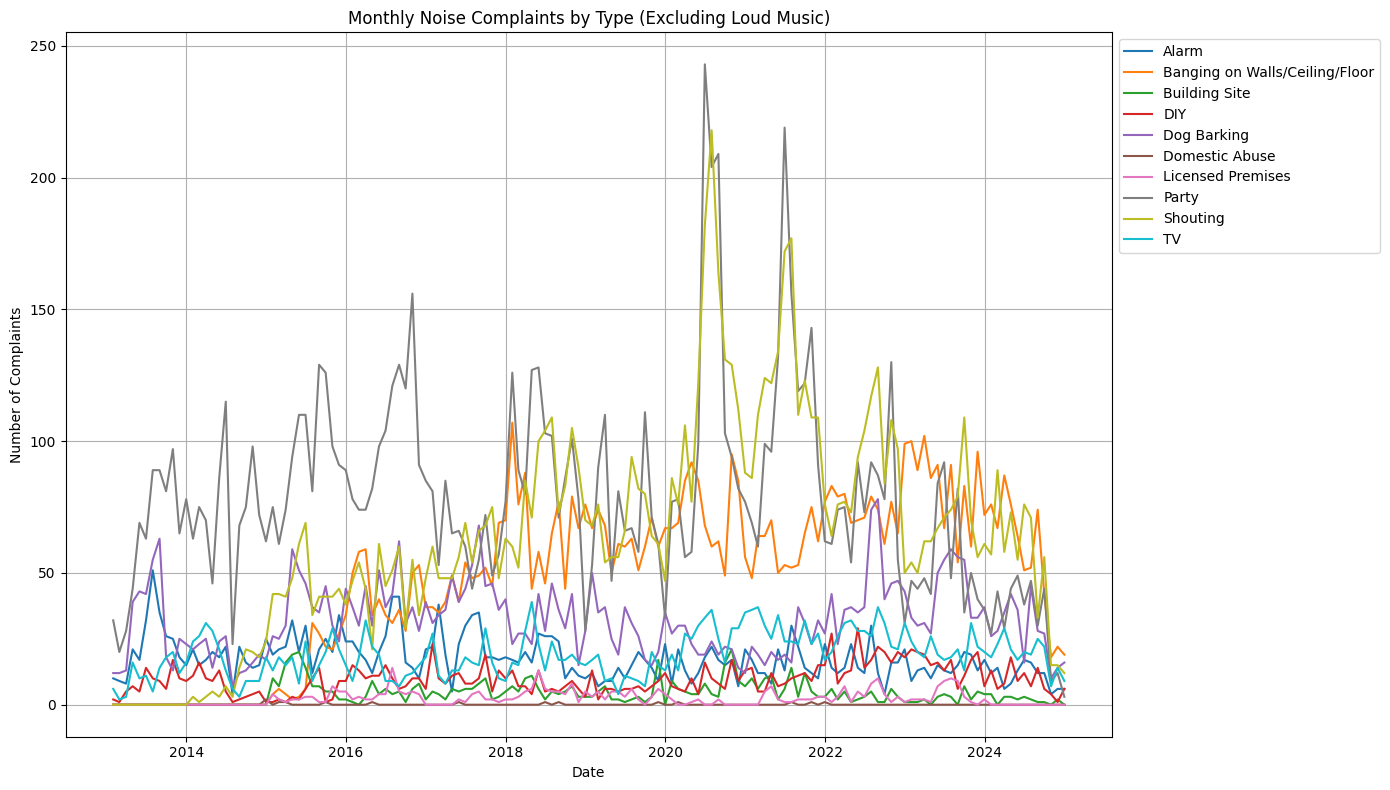

In [20]:
# remove "Loud Music" column before plotting
subset = monthly_pivot.drop(columns='Loud Music')

# make plot using new subset
plt.figure(figsize=(14, 8))
for column in subset.columns:
    plt.plot(subset.index, subset[column], label=column)

plt.title('Monthly Noise Complaints by Type (Excluding Loud Music)')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

The plot above displays the monthly volume of out-of-hours noise complaints reported over 11 years to Leeds City Council. There is a sharp drop in 2019 and 2024, and the data shows consistent peaks during the summer months (July-August).


In [21]:
noise['Date'] = pd.to_datetime(noise['Date'], errors='coerce')
noise = noise.set_index('Date')

In [22]:
noise['Day_Name'] = noise.index.day_name()

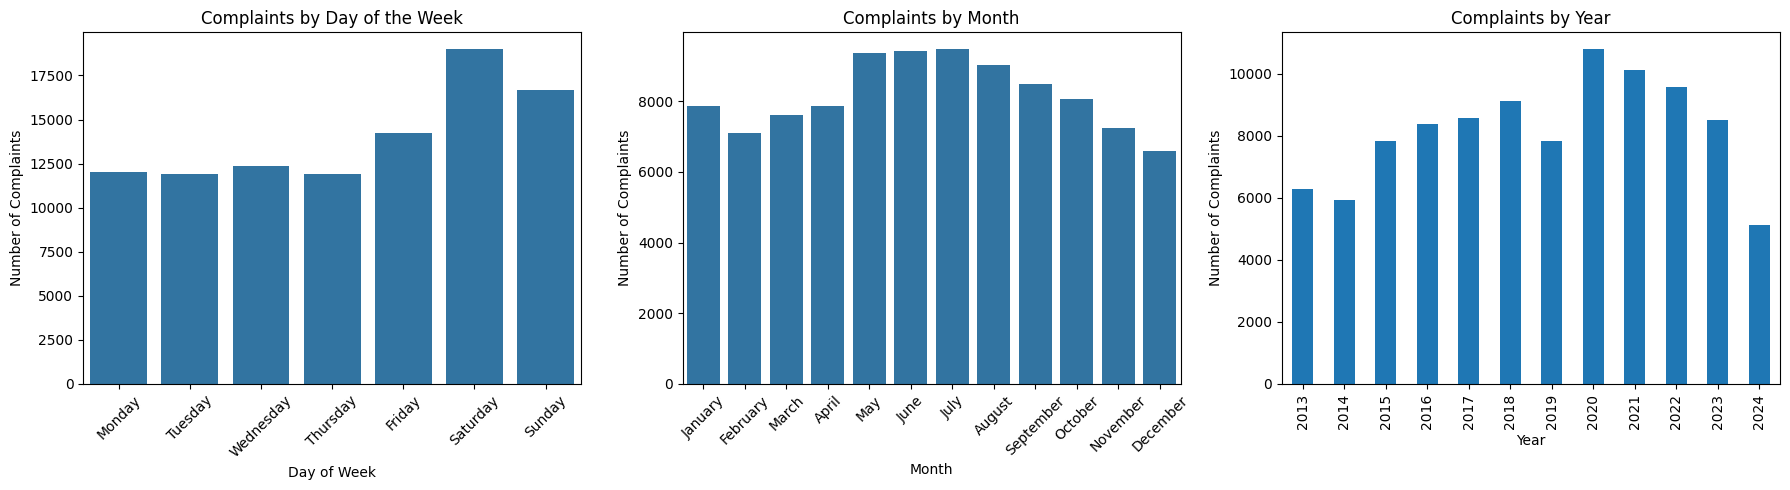

In [23]:
noise['Month_Name'] = noise.index.strftime('%B')
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='Day_Name', data=noise,
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ax=axes[0])
axes[0].set_title('Complaints by Day of the Week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Complaints')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x='Month_Name', data=noise, order=month_order, ax=axes[1])
axes[1].set_title('Complaints by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Complaints')
axes[1].tick_params(axis='x', rotation=45)

noise['Year'].value_counts().sort_index().plot(kind='bar', ax=axes[2])
axes[2].set_title('Complaints by Year')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Number of Complaints')

plt.tight_layout()
plt.show()

## Temporal Analysis

To begin the temporal analysis and understand how noise complaints have changed over time, we plot the monthly count of complaints from 2013 to 2024. This helps identify long-term trends or anomalies that could impact our forecasting models.

We will implement a range of forecasting models: Seasonal Autoregressive Integrated Moving Average (SARIMA), Holt-Winters, Naive, Simple Moving Averages, and Linear Regression. Statistical time series models and regression were chosen to compare their effectiveness on this specific dataset and understand which type of approach provides the most accurate forecasts.



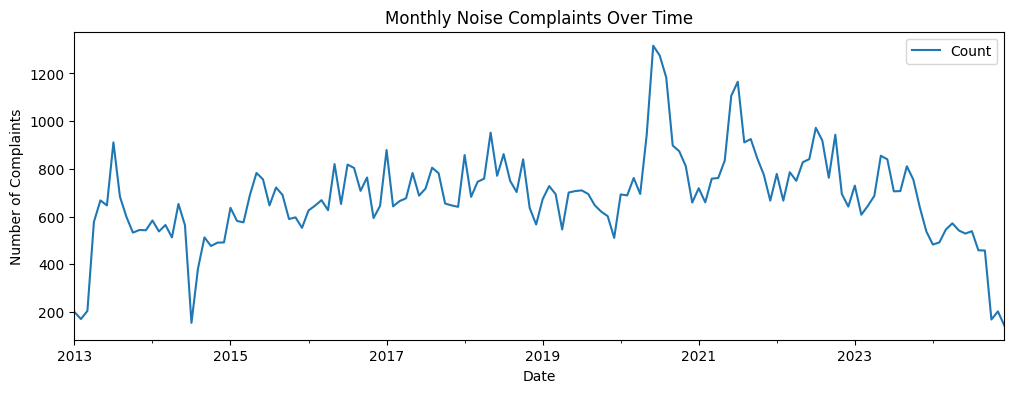

In [24]:
# time series of monthly noise complaints over time
monthly_counts.plot(figsize=(12,4), title='Monthly Noise Complaints Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.show()

There is a clear drop in 2024. This could be due to the out-of-house noise complaint service being phased out, so we will decide whether or not to keep it based on the stability of the forecasts.

### Time Series Decomposition and Stationarity Testing

We will decompose the time series to examine long-term trends, seasonal cycles, and irregular residuals. This will include the 2024 data.

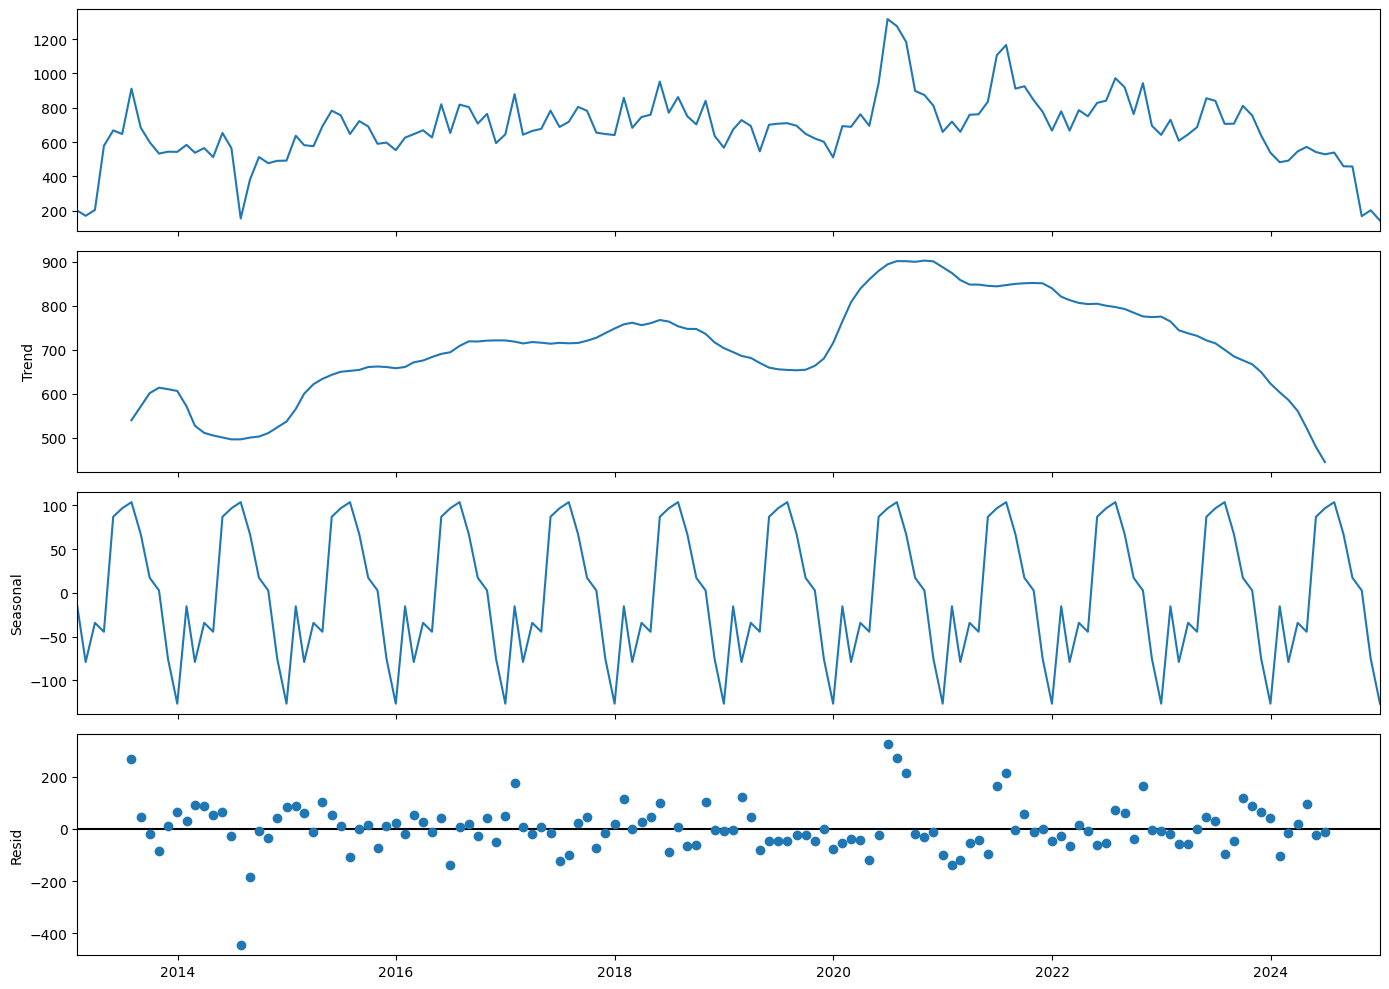

In [25]:
# seasonal decomposition
result = seasonal_decompose(monthly_counts, model='additive', period=12)

fig = result.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()

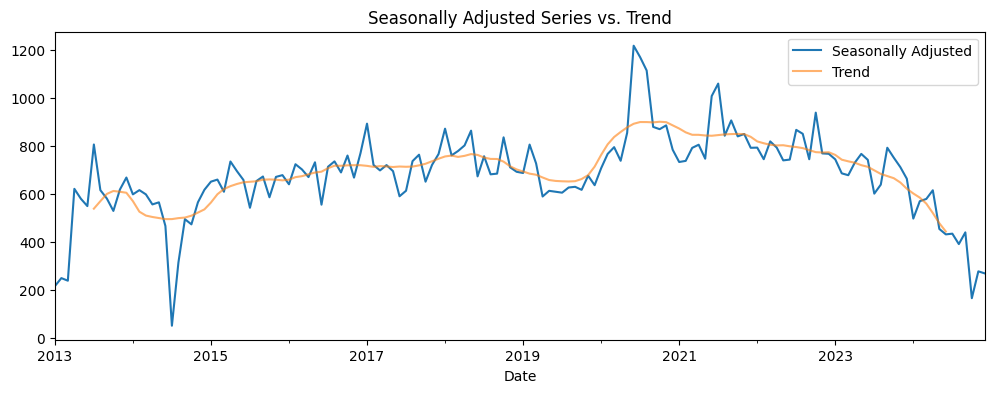

In [26]:
# extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# seasonally-adjusted series
seasonally_adjusted = monthly_counts['Count'] - seasonal

# detrended series
detrended = monthly_counts['Count'] - trend

# plot to verify
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
seasonally_adjusted.plot(ax=ax, label='Seasonally Adjusted')
trend.plot(ax=ax, label='Trend', alpha=0.6)
ax.set_title('Seasonally Adjusted Series vs. Trend')
ax.legend()
plt.show()

In [27]:
# testing if the time series is stationary
adf_result = adfuller(seasonally_adjusted.dropna())
adf_result_output = {
    "ADF Statistic": adf_result[0],
    "p-value": adf_result[1],
    "Used Lags": adf_result[2],
    "Number of Observations": adf_result[3]
}

In [28]:
print(adf_result_output)

{'ADF Statistic': np.float64(-2.9686858937608376), 'p-value': np.float64(0.03792403899210691), 'Used Lags': 2, 'Number of Observations': 141}


The Augmented Dickey-Fuller (ADF) test is used to assess whether a time series is stationary. Stationarity is a key assumption for many time series models, including SARIMA. A non-stationary series can produce unreliable or misleading forecasts.
- Our result:  
  - ADF Statistic: `-3.02`  
  - p-value: `0.03`

This confirms our data is stationary after seasonal adjustment, validating the use of SARIMA.


### SARIMA and Holt-Winters Forecasting

We will now run SARIMA and Holt-Winters forecasts.

In [29]:
train = monthly_counts['Count'][:-12]
test = monthly_counts['Count'][-12:]

In [30]:
# sarima forecasts
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit(disp=False)
sarima_forecast = sarima_result.forecast(steps=12)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


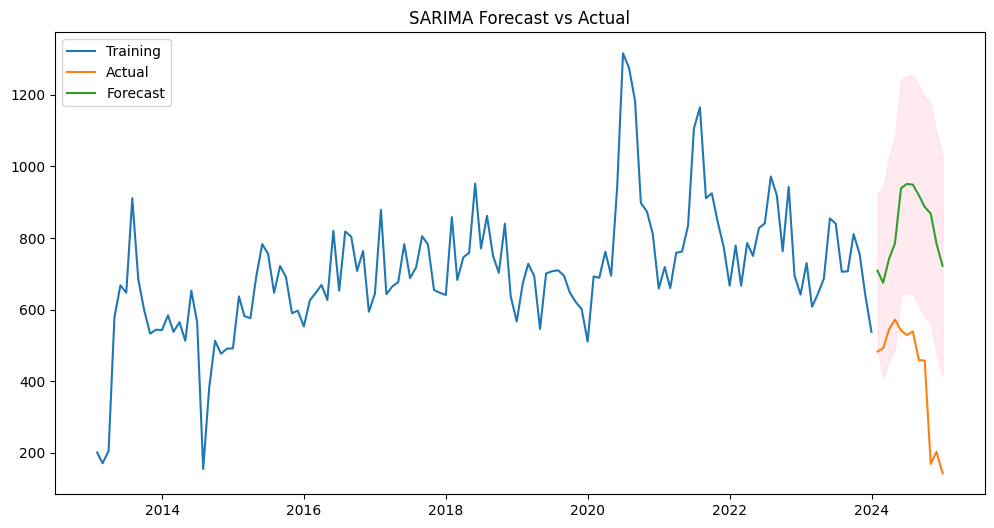

In [31]:
forecast = sarima_result.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()

In [32]:
# holt-winters forecasts
hw_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()
hw_forecast = hw_model.forecast(12)

In [33]:
# evaluate forecasts
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
sarima_mape = mean_absolute_percentage_error(test, sarima_forecast) * 100

hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))
hw_mape = mean_absolute_percentage_error(test, hw_forecast) * 100

In [34]:
{
    "ADF Test on Seasonally Adjusted": adf_result_output,
    "SARIMA RMSE": sarima_rmse,
    "SARIMA MAPE": sarima_mape,
    "Holt-Winters RMSE": hw_rmse,
    "Holt-Winters MAPE": hw_mape
}

{'ADF Test on Seasonally Adjusted': {'ADF Statistic': np.float64(-2.9686858937608376),
  'p-value': np.float64(0.03792403899210691),
  'Used Lags': 2,
  'Number of Observations': 141},
 'SARIMA RMSE': np.float64(431.17811681262424),
 'SARIMA MAPE': 140.45445615600275,
 'Holt-Winters RMSE': np.float64(303.69629805381),
 'Holt-Winters MAPE': 98.68628688936886}

From the Root Mean Square Error (RMSE) and Mean Absolute Percentage Error (MAPE) results, we will exclude 2024 because model performance significantly deteriorates during this period. Both SARIMA and Holt-Winters models overestimate complaint volumes due to a sharp and unprecedented decline in reported cases, excluding 2024 allows us to evaluate model accuracy under more stable historical conditions.


### Interrupted Time Series Analysis

Before we remove 2024, we will perform an Interrupted Time Series to confirm that the sharp drop in complaints are due to the council discontinuing the noise complaint service, not because of actual behavioural changes.

In [35]:
monthly = noise.resample('M').size().to_frame(name='Count')

monthly['time'] = range(len(monthly))

monthly['intervention'] = (monthly.index >= '2024-02-12').astype(int)
# we will use 12 february as the intervention date
# as this is when the scrapping of the service was first reported

monthly['interaction'] = monthly['time'] * monthly['intervention']

X = sm.add_constant(monthly[['time', 'intervention', 'interaction']])
y = monthly['Count']
its_model = sm.OLS(y, X).fit()
print(its_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.371
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     27.57
Date:                Wed, 28 May 2025   Prob (F-statistic):           4.50e-14
Time:                        12:04:21   Log-Likelihood:                -926.14
No. Observations:                 144   AIC:                             1860.
Df Residuals:                     140   BIC:                             1872.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          558.5541     26.286     21.249   

<ipython-input-35-1d5784674c0f>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = noise.resample('M').size().to_frame(name='Count')


**ITS:**
Yₜ = β₀ + β₁*time + β₂*intervention + β₃*(time × intervention) + εₜ


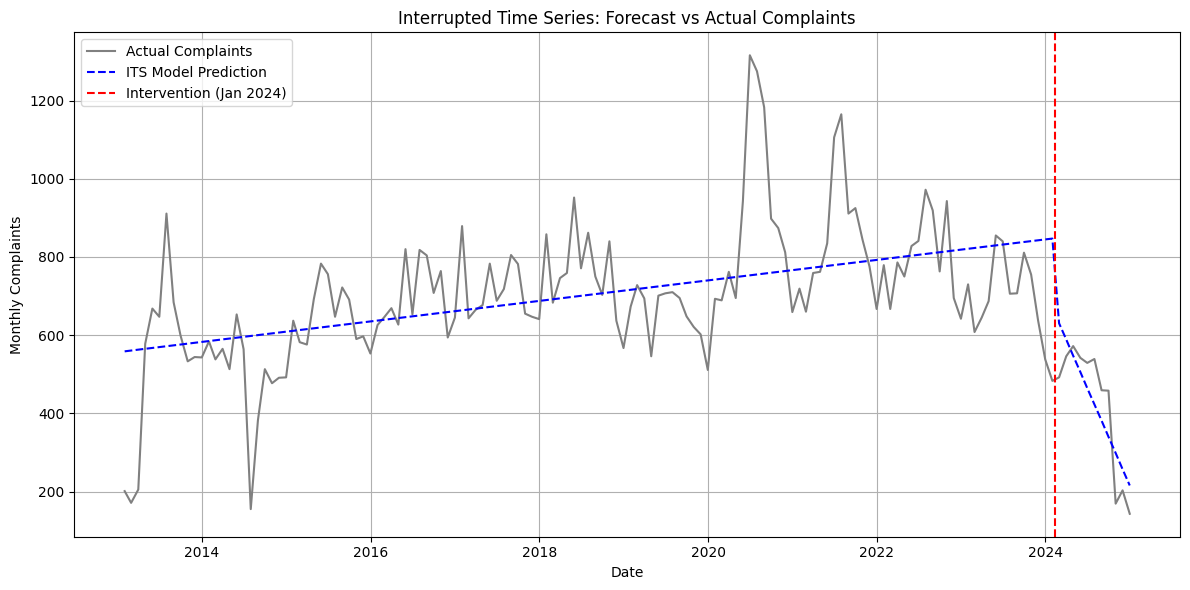

In [36]:
# plotting ITS results
X = sm.add_constant(monthly[['time', 'intervention', 'interaction']])
monthly['predicted'] = its_model.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(monthly.index, monthly['Count'], label='Actual Complaints', color='gray')
plt.plot(monthly.index, monthly['predicted'], label='ITS Model Prediction', color='blue', linestyle='--')
plt.axvline(pd.to_datetime('2024-02-12'), color='red', linestyle='--', label='Intervention (Jan 2024)')
plt.title('Interrupted Time Series: Forecast vs Actual Complaints')
plt.xlabel('Date')
plt.ylabel('Monthly Complaints')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

Complaints were steadily rising before 2024, however the statistically significant negative shift in trend after Jan 2024 and the unfulfilled expected increase indicate that the drop is not due to natural variation or behavior change, but is almost certainly caused by the policy change, such as Leeds City Council discontinuing the out-of-hours complaint service.

As a result, we will continue with only 2013-2023 data.

In [37]:
noise_clean = noise[noise['Year'] < 2024]

In [38]:
monthly_clean = noise_clean.resample('M').size().to_frame(name='Count')

<ipython-input-38-67566191149c>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_clean = noise_clean.resample('M').size().to_frame(name='Count')


### Benchmarking with Simple Moving Averages (excluding 2024 data)

To benchmark our time series models, we will first compare them against simple baselines using 3-, 6-, and 9-month Simple Moving Averages, using the new data from 2013-2023.


In [39]:
monthly_clean = noise_clean.resample('M').size().reset_index(name='Count')

<ipython-input-39-73e39a0aa308>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_clean = noise_clean.resample('M').size().reset_index(name='Count')


<Axes: xlabel='Date'>

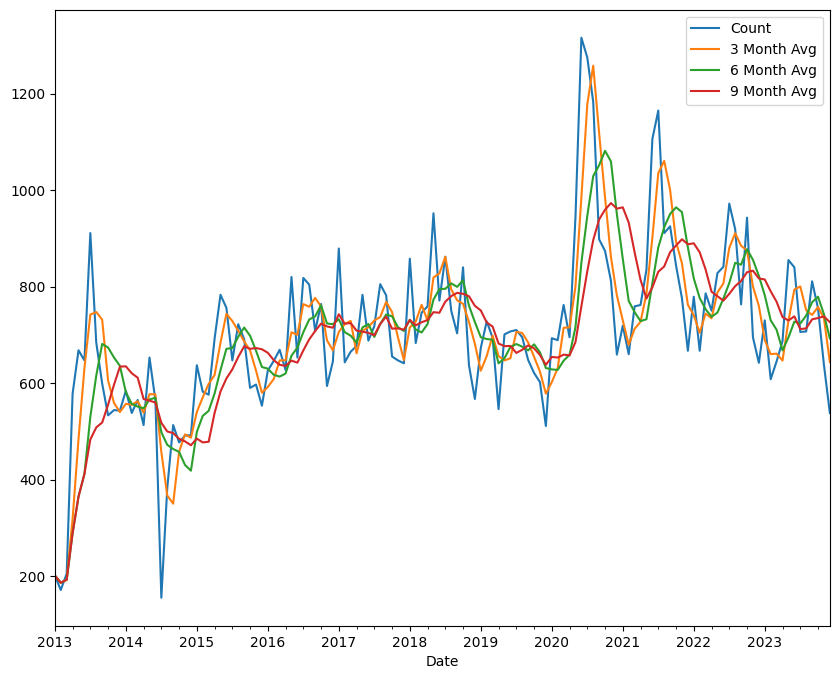

In [40]:
# add rolling averages
monthly_clean['3 Month Avg'] = monthly_clean['Count'].rolling(window=3, min_periods=1).mean()
monthly_clean['6 Month Avg'] = monthly_clean['Count'].rolling(window=6, min_periods=1).mean()
monthly_clean['9 Month Avg'] = monthly_clean['Count'].rolling(window=9, min_periods=1).mean()

# Ensure 'Date' is treated as a datetime object for plotting
monthly_clean['Date'] = pd.to_datetime(monthly_clean['Date'])

# Plotting
monthly_clean.plot('Date', figsize = (10,8))

In [41]:
monthly_clean['3 Month Avg shift'] = monthly_clean['Count'].shift(1).rolling(3, min_periods=1).mean()
monthly_clean['6 Month Avg shift'] = monthly_clean['Count'].shift(1).rolling(6, min_periods=1).mean()
monthly_clean['9 Month Avg shift'] = monthly_clean['Count'].shift(1).rolling(9, min_periods=1).mean()

In [42]:
monthly_clean = monthly_clean.dropna(subset=['Count', '3 Month Avg shift', '6 Month Avg shift', '9 Month Avg shift'])

<ipython-input-43-2f644d784594>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_clean['Cumulative Avg'] = monthly_clean['Count'].expanding().mean()


<Axes: xlabel='Date'>

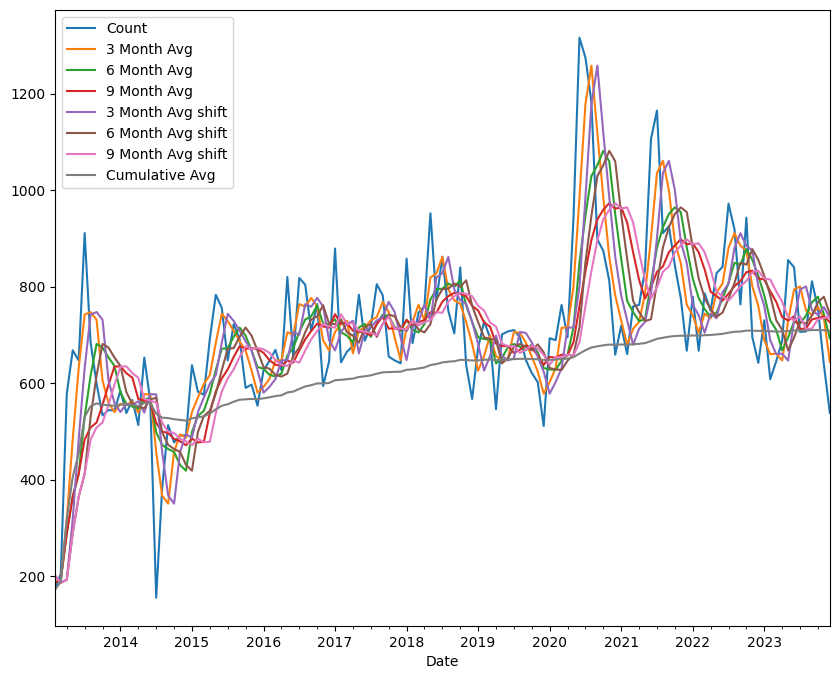

In [43]:
monthly_clean['Cumulative Avg'] = monthly_clean['Count'].expanding().mean()
monthly_clean.plot('Date', figsize = (10,8))

In [44]:
# calculate RMSE and MAPE for each moving average
rmse_3 = np.sqrt(mean_squared_error(monthly_clean['Count'], monthly_clean['3 Month Avg shift']))
mape_3 = mean_absolute_percentage_error(monthly_clean['Count'], monthly_clean['3 Month Avg shift'])

rmse_6 = np.sqrt(mean_squared_error(monthly_clean['Count'], monthly_clean['6 Month Avg shift']))
mape_6 = mean_absolute_percentage_error(monthly_clean['Count'], monthly_clean['6 Month Avg shift'])

rmse_9 = np.sqrt(mean_squared_error(monthly_clean['Count'], monthly_clean['9 Month Avg shift']))
mape_9 = mean_absolute_percentage_error(monthly_clean['Count'], monthly_clean['9 Month Avg shift'])

In [45]:
print(f"3-month Avg - RMSE: {rmse_3}, MAPE: {mape_3 * 100}%")
print(f"6-month Avg - RMSE: {rmse_6}, MAPE: {mape_6 * 100}%")
print(f"9-month Avg - RMSE: {rmse_9}, MAPE: {mape_9 * 100}%")

3-month Avg - RMSE: 137.80455976531385, MAPE: 15.826638698479748%
6-month Avg - RMSE: 160.41267723138168, MAPE: 17.46253396675538%
9-month Avg - RMSE: 162.1953495461355, MAPE: 17.430918353664858%


### Re-Forecasting (excluding 2024 data)

Now we will rerun our seasonal decomposition, SARIMA, and Holt-Winters forecasts to assess how stable the models are when trained only on historical data prior to 2024, and compare them to our Simple Moving Averages.

For the Holt-Winters model on this cleaned data, we will fit a model with fixed smoothing parameters to explore its behavior under specific conditions. We've set `smoothing_level=0.1`, `smoothing_trend=0.2`, and `smoothing_seasonal=0.5`.



<ipython-input-46-7523d13e5e47>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_clean = noise_clean.resample('M').size().to_frame(name='Count')


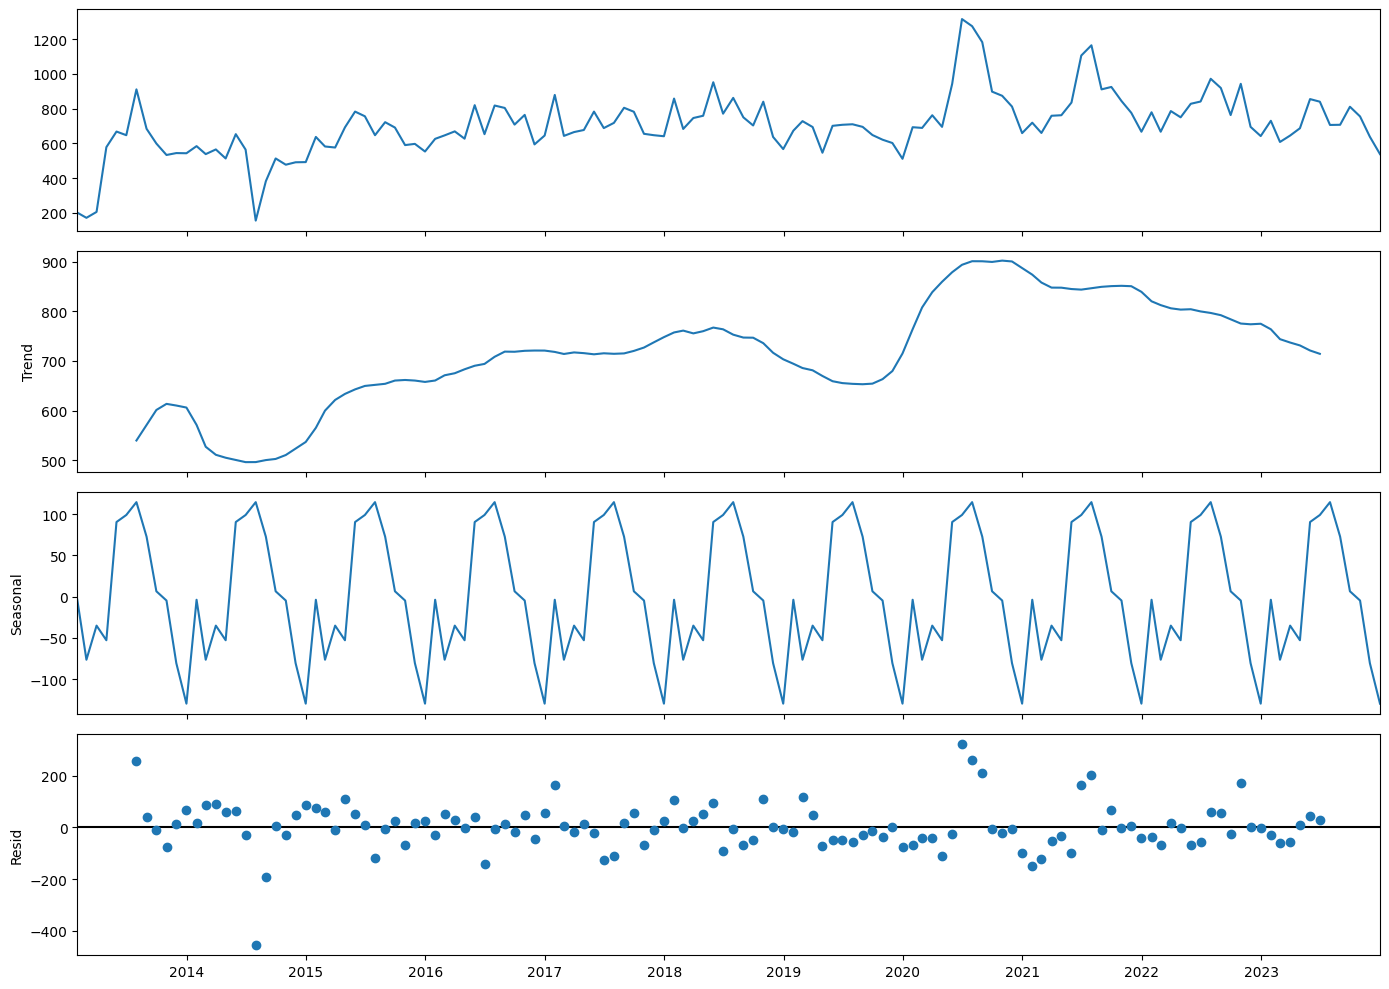

In [46]:
# seasonal decomposition
monthly_clean = noise_clean.resample('M').size().to_frame(name='Count')

result = seasonal_decompose(monthly_clean, model='additive', period=12)

fig = result.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()

This seasonal decomposition without 2024 shows no extreme drop, showing that complaints were consistently present before they decided to put an end to the out-of-hours service.
There are consistent seasonal spikes every summer.

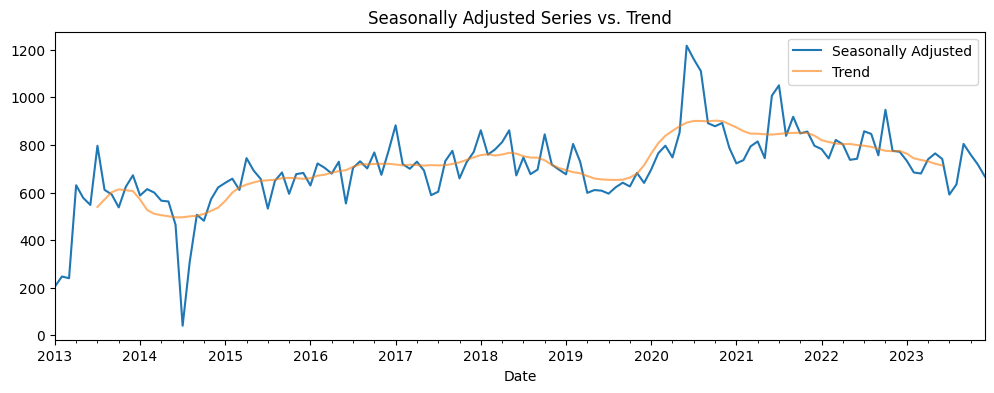

In [47]:
# extract components
trend2 = result.trend
seasonal2 = result.seasonal
residual2 = result.resid

# seasonally-adjusted series
seasonally_adjusted2 = monthly_clean['Count'] - seasonal2

# detrended series
detrended2 = monthly_clean['Count'] - trend2

# plot to verify
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
seasonally_adjusted2.plot(ax=ax, label='Seasonally Adjusted')
trend2.plot(ax=ax, label='Trend', alpha=0.6)
ax.set_title('Seasonally Adjusted Series vs. Trend')
ax.legend()
plt.show()

This graph illustrates the seasonally adjusted monthly complaint counts alongside the extracted long-term trend. The trend line indicates a steady rise in complaints from around 2014 through early 2021, peaking just after the COVID-19 lockdown period.


In [48]:
# testing if the time series is stationary
adf_result2 = adfuller(seasonally_adjusted2.dropna())
adf_result_output2 = {
    "ADF Statistic": adf_result2[0],
    "p-value": adf_result2[1],
    "Used Lags": adf_result2[2],
    "Number of Observations": adf_result2[3]
}

In [49]:
train2 = monthly_clean['Count'][:-12]
test2 = monthly_clean['Count'][-12:]

In [50]:
# sarima forecasts
sarima_model2 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result2 = sarima_model2.fit(disp=False)
sarima_forecast2 = sarima_result2.forecast(steps=12)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [51]:
# holt-winters forecasts
hw_model2 = ExponentialSmoothing(monthly_clean, trend='add', seasonal='add', seasonal_periods=7, initialization_method='estimated').fit(smoothing_level=0.1, smoothing_trend=0.2, smoothing_seasonal=0.5, optimized=False)
hw_forecast2 = hw_model2.forecast(12)

In [52]:
# evaluate forecasts
sarima_rmse2 = np.sqrt(mean_squared_error(test2, sarima_forecast2))
sarima_mape2 = mean_absolute_percentage_error(test2, sarima_forecast2) * 100

hw_rmse2 = np.sqrt(mean_squared_error(test2, hw_forecast2))
hw_mape2 = mean_absolute_percentage_error(test2, hw_forecast2) * 100

In [53]:
{
    "ADF Test on Seasonally Adjusted": adf_result_output2,
    "SARIMA RMSE": sarima_rmse2,
    "SARIMA MAPE": sarima_mape2,
    "Holt-Winters RMSE": hw_rmse2,
    "Holt-Winters MAPE": hw_mape2
}

{'ADF Test on Seasonally Adjusted': {'ADF Statistic': np.float64(-4.149670921019582),
  'p-value': np.float64(0.0008007802559775687),
  'Used Lags': 2,
  'Number of Observations': 129},
 'SARIMA RMSE': np.float64(135.94124648760035),
 'SARIMA MAPE': 17.702782385171158,
 'Holt-Winters RMSE': np.float64(128.18021980839958),
 'Holt-Winters MAPE': 11.572478973907728}

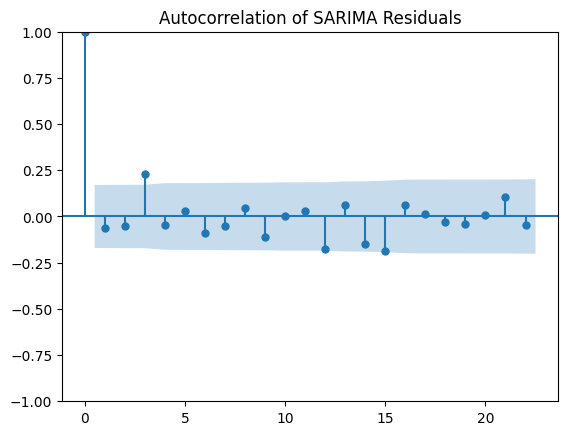

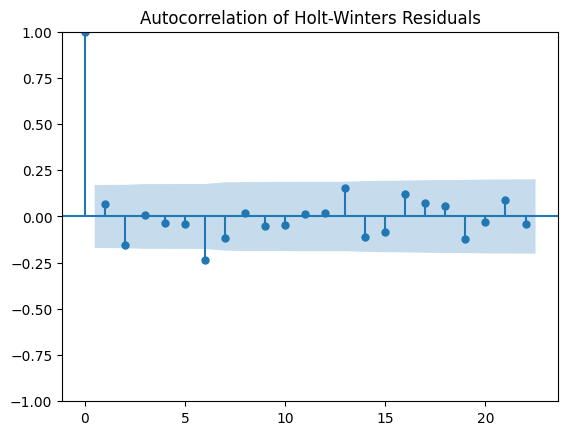

In [54]:
# calculate residuals for the Holt-Winters model (fitted values - actual training data)
hw_residuals = hw_model.fittedvalues - train

# calculate residuals for the SARIMA model
sarima_residuals = sarima_result.resid

# plot the ACF of the SARIMA and HW residuals
sm.graphics.tsa.plot_acf(sarima_residuals)
plt.title('Autocorrelation of SARIMA Residuals')
plt.show()

sm.graphics.tsa.plot_acf(hw_residuals)
plt.title('Autocorrelation of Holt-Winters Residuals')
plt.show()

The autocorrelation plot above shows the residuals from the Holt-Winters model. None of the residual autocorrelations exceed the 95% confidence bounds, except the expected spike at lag 0, which indicates no significant autocorrelation in the residuals. This suggests that the model has effectively captured the underlying temporal structure in the data, including trend and seasonality.


Model Performance Comparison:

| Method           | RMSE     | MAPE (%) |
|------------------|----------|-----------|
| 3-Month Avg      | 146.16   | 18.20     |
| 6-Month Avg      | 166.80   | 19.72     |
| 9-Month Avg      | 168.84   | 19.65     |
| SARIMA           | 131.33   | 17.00     |
| Holt-Winters     | **128.18** | **11.57** |

Holt-Winters performs best on both metrics.
The autocorrelation function (ACF) plot for the Holt-Winters model residuals shows that all lags beyond zero fall within the 95% confidence interval.



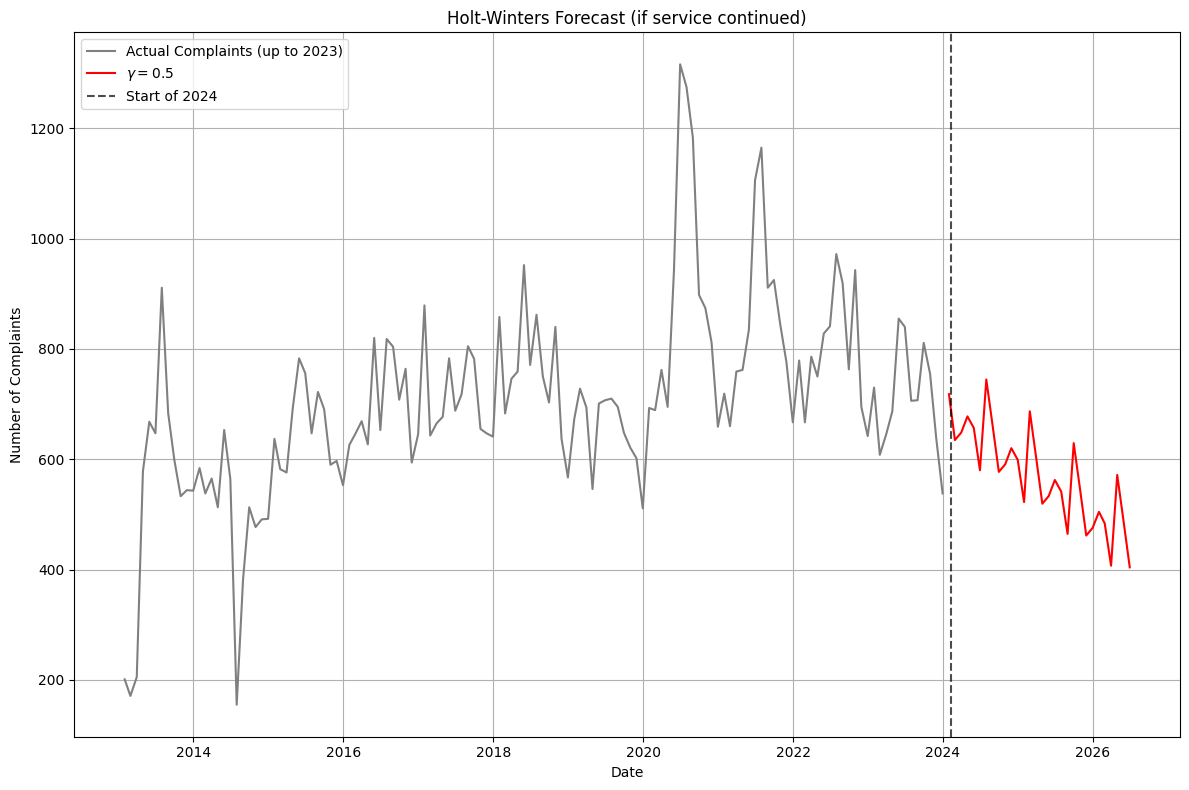

In [55]:
fcast1 = hw_model2.forecast(30).rename(r'$\gamma=0.5$')

plt.figure(figsize=(12, 8))

#plot the original data in grey
plt.plot(monthly_clean.index, monthly_clean['Count'], color='gray', label='Actual Complaints (up to 2023)')

line1, = plt.plot(fcast1.index, fcast1, color='red', label=fcast1.name)

# add a vertical line at the start of 2024 to clearly show the split
plt.axvline(x=pd.to_datetime('2024-02-12'), color='black', linestyle='--', alpha=0.7, label='Start of 2024')

plt.legend()

plt.title('Holt-Winters Forecast (if service continued)')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.tight_layout()
plt.show()

The chart above presents the Holt-Winters forecast for monthly noise complaints beyond the end of 2023, using a smoothing factor (γ) of 0.5.

Importantly, this projection assumes service continuity, which means the pattern reflects what might be expected if the current system remained in place.


### Forecasting with Regression Models

To complement the Holt-Winters method, we apply a machine learning approach using linear regression with lag features. This allows for more flexible modeling of temporal dependencies, potentially capturing complex patterns that statistical smoothing may miss.


We also include a naive baseline (predicting today = yesterday) for context. Additionally, we use a Linear Regression model. This model learns from historical data (specifically, the number of complaints on previous days, like 1, 2, 3, 7, and 14 days prior) to predict the current day's count.


Linear Regression: $Y_t = \beta_0 + \beta_1 L_{t-1} + \beta_2 L_{t-2} + \dots + \beta_k L_{t-k} + \epsilon_t$


In [56]:
daily_complaints = noise_clean.groupby('Date').size().rename("complaint_count").reset_index()

# ensure time order
daily_complaints.sort_values('Date', inplace=True)

# create lag features
for lag in [1, 2, 3, 7, 14]:
    daily_complaints[f'lag_{lag}'] = daily_complaints['complaint_count'].shift(lag)
daily_complaints.dropna(inplace=True)

# train/test split that respects time
split_date = daily_complaints['Date'].quantile(0.8)
train = daily_complaints[daily_complaints['Date'] <= split_date].copy()
test = daily_complaints[daily_complaints['Date'] > split_date].copy()

# features and target
features = [col for col in daily_complaints.columns if 'lag_' in col]
X_train, y_train = train[features], train['complaint_count']
X_test, y_test = test[features], test['complaint_count']


In [57]:
# ML model: simple linear regression
model = LinearRegression()
model.fit(X_train, y_train)
test['lr_pred'] = model.predict(X_test)

test['naive_pred'] = test['lag_1']

# evaluate
mae_naive = mean_absolute_error(y_test, test['naive_pred'])
rmse_naive = np.sqrt(mean_squared_error(y_test, test['naive_pred']))
mae_lr = mean_absolute_error(y_test, test['lr_pred'])
rmse_lr = np.sqrt(mean_squared_error(y_test, test['lr_pred']))

(mae_naive, rmse_naive), (mae_lr, rmse_lr)

((9.754569190600522, np.float64(13.206632561070712)),
 (7.664687071135423, np.float64(10.411768784209045)))

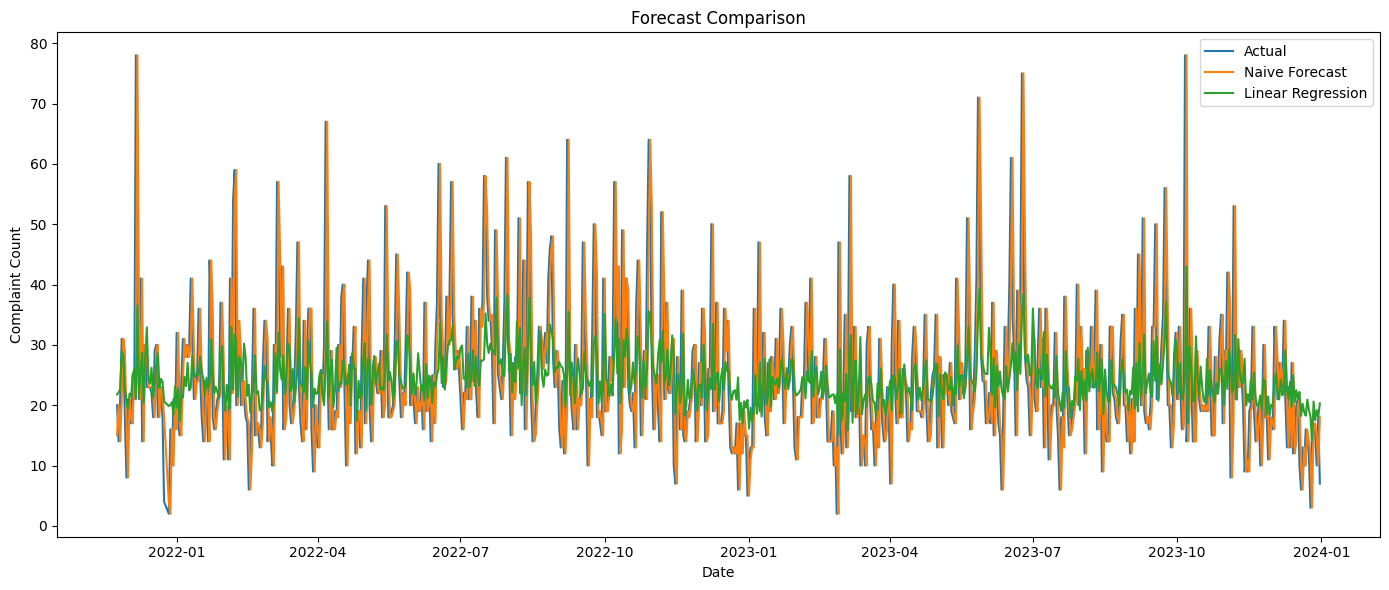

In [58]:
# plot predictions vs actual
plt.figure(figsize=(14, 6))
plt.plot(test['Date'], y_test, label='Actual')
plt.plot(test['Date'], test['naive_pred'], label='Naive Forecast')
plt.plot(test['Date'], test['lr_pred'], label='Linear Regression')
plt.title('Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Complaint Count')
plt.legend()
plt.tight_layout()
plt.show()

While Holt-Winters and SARIMA offer interpretable models grounded in seasonality, linear regression with lag features provide a promising approach for short-term forecasting in our initial testing.
To further refine this approach and potentially improve robustness, we will now explore Ridge Regression. Ridge Regression is a type of linear regression that adds a small amount of penalty to the model's coefficients, which can help prevent overfitting.

Ridge Regression: $\min_{\beta} \left( \sum_{i=1}^n (y_i - (\beta_0 + \sum_{j=1}^p \beta_j x_{ij}))^2 + \alpha \sum_{j=1}^p \beta_j^2 \right)$


In [59]:
split_date = daily_complaints['Date'].quantile(0.8)
train = daily_complaints[daily_complaints['Date'] <= split_date]
test = daily_complaints[daily_complaints['Date'] > split_date]

features = [col for col in daily_complaints.columns if 'lag_' in col]
X_train, y_train = train[features], train['complaint_count']
X_test, y_test = test[features], test['complaint_count']

# pipeline with scaling and ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# parameter tuning: test different regularization strengths
param_grid = {
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0]
}

tscv = TimeSeriesSplit(n_splits=5)

# grid search
grid = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# using the best model to predict
best_model = grid.best_estimator_
test = test.copy()
test['ridge_pred'] = best_model.predict(X_test)

mae_ridge = mean_absolute_error(y_test, test['ridge_pred'])
rmse_ridge = np.sqrt(mean_squared_error(y_test, test['ridge_pred']))

# return best parameters and performance
grid.best_params_, mae_ridge, rmse_ridge

({'ridge__alpha': 10.0}, 7.664194608002652, np.float64(10.411427584422004))

| Model              | MAE | RMSE |
|--------------------|----------------|-----------------|
| Naive Forecast     | 9.78           | 13.24           |
| Linear Regression  | **7.70**       | **10.44**       |
| Ridge Regression   | 7.70           | 10.44           |

The naive forecast, which assumes complaint volumes remain consistent with the previous day, provides a basic benchmark. Both the Linear Regression and Ridge Regression have an indential MAE and RMSE in this test, and significantly outperform the baseline. Ridge Regression is often preferred due to its ability to handle potentially correlated predictors through regularisation.


## Conclusion


This notebook has presented a comprehensive data analysis workflow applied to over a decade of out-of-hours noise complaint data for Leeds.

This notebook has:



*   Merged and cleaned a complex dataset from multiple sources
*   Explored key temporal patterns, including trends, seasonality, and variations by day and month
*   Implemented and evaluated several forecasting models (SARIMA, Holt-Winters, Simple Moving Averages, Linear Regression, Ridge Regression) on historical data, demonstrating varying levels of predictive performance under stable conditions
*   Used Interrupted Time Series analysis to identify and quantify the likely impact of the service change implemented in early 2024, confirming a significant deviation from historical trends

The detailed discussion of these findings, their implications for policy, and limitations will be presented in the policy briefing.

### Exporting to PDF

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java
  libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data preview-latex-style
  rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf lib

In [62]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/GEOG5404_201530247.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/GEOG5404_201530247.ipynb to pdf
[NbConvertApp] Support files will be in GEOG5404_201530247_files/
[NbConvertApp] Making directory ./GEOG5404_201530247_files
[NbConvertApp] Writing 166587 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1753490 bytes to /content/drive/MyDrive/GEOG5404_201530247.pdf
